# Unsupervised Landcover Classification via NMF

In [3]:
data_filepath = str(u"C:\\Users\\Alison Link\\Documents\\INET4710\\FinalProjectData\\")

train_images = [
    data_filepath + u'naip\\2015\\twincities\\m_4409307_ne_15_1_20150927_20151221.tif' # just west of downtown St. Paul (by St. Paul campus)  
]

test_images = [
    data_filepath + u'naip\\2015\\twincities\\m_4409306_ne_15_1_20150930_20151221.tif', # downtown Minneapolis
    data_filepath + u'naip\\2015\\twincities\\m_4409307_nw_15_1_20150927_20151221.tif', # just east of downtown Minneapolis
    data_filepath + u'naip\\2015\\twincities\\m_4409308_nw_15_1_20150927_20151221.tif', # downtown St. Paul
    data_filepath + u'naip\\2015\\duluth\\m_4609215_se_15_1_20150922_20151221.tif', # Duluth north w/ some lake
    data_filepath + u'naip\\2015\\duluth\\m_4609223_nw_15_1_20150922_20151221.tif', # Duluth w/ some lake
    data_filepath + u'naip\\2015\\duluth\\m_4609216_sw_15_1_20150922_20151221.tif' # Duluth downtown w/ lots of lake  
]

import matplotlib.pyplot as plt
%matplotlib inline

## Reshape Data

The first step in being able to run the NAIP imagery through a machine learning model is to coerce it into a format that is recognizable by scikit-learn and other standard libraries.  Generally, these kinds of modeling tools expect data to come formatted as a list.  Unfortunately, NAIP's standard structure looks like this:

> ~5580 pixels (width) x ~7580 pixels (height) x 4 spectral bands (red, green, blue, near-infrared)

The `make_img_long()` function below reshapes the data so it comes out like this:

> 4 bands (columns) x ~4,200,000 pixels (rows)

In [8]:
import time
import numpy as np
import pandas as pd
import rasterio

def make_img_long(img_filepath, compute_ndvi=False):
    start = time.time()
    
    dataset = rasterio.open(img_filepath)
    img_metadata = dataset.meta.copy() # need to make a copy of this so we're not manipulating it in place
    img_3darray = dataset.read()
    
    # Save height and width values so we can reconstruct the image later
    height = img_3darray.shape[1] 
    width = img_3darray.shape[2]
    
    # Convert raster to list, then to dataframe
    # See: https://gis.stackexchange.com/questions/32995/how-to-fully-load-a-raster-into-a-numpy-array
    img_list = img_3darray.transpose(1, 2, 0).reshape(-1, 4).astype(float)
    out_df = pd.DataFrame(data=img_list)
    
    if compute_ndvi:
        print("Computing NDVI")
        
        # NDVI = (IR band - red band) / (IR band + red band)
        # See: https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/vegetation-indices-NDVI-in-python/
        def ndvi_func(bands):
            #print(bands)
            #print(str(bands[0]) + " : " + str(bands[3]))
            if (bands[1] + bands[4]) > 0:
                ndvi = (bands[4] - bands[1]) / (bands[4] + bands[1])
                #print(ndvi)
                if ndvi > 0:
                    return(ndvi)
                else:
                    return(ndvi)
            else:
                return(0)
        
        out_df['ndvi'] = [ndvi_func(row) for row in out_df.itertuples()]
    
    stop = time.time()
    runtime = round(stop - start, 3)
    print("Transformed image to dataframe in " + str(runtime) + " seconds.")
    return(out_df, img_metadata)

Because each NAIP image contains over 4,000,000 pixels, it takes approximately 1 minute to run this function.  Note that we are also computing the NDVI value for each pixel as we go along.  We are also saving the image metadata for later use, as this will come in handy when we need to coerce the image back into its original width and height.

In [9]:
train_img_df, train_img_metadata = make_img_long(train_images[0], compute_ndvi=True)

Computing NDVI
Transformed image to dataframe in 63.162 seconds.


## Train NMF Models

I initially started the modeling process with a very "naive" approach: I simply pumped the training image data through scikit-learn's NMF function, and told it to extract a 2-, 3-, 4-, 5-, or 6- class model with no additional discernment or segmentation between pixels being passed to the model.  The results were less than impressive:

[insert screenshot here]

Fortunately, a group of researchers at the EPA has an interesting finding when conducting a similar image classification task, also on NAIP imagery.  They make an important observation that seemed relevant to helping improve the model:

> "Shadows cast by vegetation and structures add significant noise to imagery at one meter resolution. Shadows typically appear at the edges of tall buildings and trees, and mottled within tree canopies, and are commonly misclassified as water or impervious surface. Using a binary step of classifying vegetation versus non-vegetation reduced these errors." (See: [Baynes, et al.](https://www.epa.gov/sites/production/files/2015-11/documents/baynes_esri_landcover_120313.pdf))

With this in mind, I heavily adapted the model to the final version you see below.  Because the training and test fit process share so many similar steps, the `fit_ndvi_segmented_nmf()` function below can actually perform _both_ the training and test fits, based on user inputs.  The function takes the following arguments:

- `model_name`: used as the beginning of the filename when saving the model to disk (recommended to use a name that acts as a reminder of which image the model was trained on)
- `img_df_long`: raster image data, coerced to a list format using `make_img_long()` function defined above
- `img_metadata`: raster image metadata, extracted from the `make_img_long()` function above, and used to coerce the data back into its original image dimensions
- `mode`: whether to train a new model ("train"), or load existing models from disk and fit to new image data ("test")
- `ndvi_water_cutoff`: determine which cutoff to use for classifying pixels as water; any pixels with NDVI values below this cutoff will be automatically classified as water
- `ndvi_pos_components`: how many land use classes to extract in the NDVI positive range (generally corresponding to vegetation)
- `ndvi_neg_components`: how many land use classes to extract in the NDVI negative range (generally corresponding to urban/built environments)
- `save_to_file` & `filename`: whether to save the resulting classified raster to disk, and which filename to use

The modeling proceeds as follows:

1. Segment the image data into three classes based on the pixels' NDVI values: 1) pixels that likely represent water; 2) pixels with positive NDVI values; 3) pixels with negative NDVI values that are greater than the cutoff value used for water

2. Train two separate models--one for pixels with positive NDVI values and one for pixels with negative NDVI values.  The user can specify how many separate land use classes (i.e. NMF components) to extract within each model.

3. Save the two models to disk, so they can be used later to classify test images.

4. For pixels with an NDVI value that is lower than the ndvi_water_cutoff threshold, simply classify these as 'water' with no additional modeling effort required.

5. For all other pixels, use the pixel weights extracted from the models to determine which class/component each pixel is most likely to belong to. This is accomplished with a simple call to `argmax` for each row in the weights matrices that are yielded from each model.

6. Coerce the input image list back into its original height and width dimensions.  Save the resulting raster to disk so it can be visualized in a GIS tool, if desired. 

In [ ]:
from sklearn.decomposition import NMF
import joblib # for saving models

def fit_ndvi_segmented_nmf(model_name, img_df_long, img_metadata, mode = "train",
                           ndvi_water_cutoff = -0.35, ndvi_pos_components=2, ndvi_neg_components=2, 
                           save_to_file=False, filename= ""):
    
    # Get pixels that are obviously water
    ndvi_water_pixels = img_df_long.loc[img_df_long['ndvi'] <= ndvi_water_cutoff]
    
    # Get pixels where NDVI value is > 0
    ndvi_pos_pixels = img_df_long.loc[img_df_long['ndvi'] > 0]
    
    # Get pixels where NDVI value is < 0
    ndvi_neg_pixels = img_df_long.loc[(img_df_long['ndvi'] > ndvi_water_cutoff) & (img_df_long['ndvi'] <= 0)]

    if mode == "train":
        # Fit NDVI positive model 
        start1 = time.time()
        ndvi_pos_model = NMF(n_components=ndvi_pos_components, init='random', random_state=0)
        ndvi_pos_model_W = ndvi_pos_model.fit_transform(ndvi_pos_pixels[[0, 1, 2, 3]]) # Pass only the 4-band pixel values to train one
        ndvi_pos_model_H = ndvi_pos_model.components_
        stop1 = time.time()
        runtime1 = round(stop1 - start1, 3)
        print("NDVI Positive Model completed in " + str(runtime1) + " seconds.")
        # Save the model for future use
        joblib.dump(ndvi_pos_model, './models/{}_NMF_{}pos_classes.joblib'.format(model_name, ndvi_pos_components)) 

        # Fit NDVI negative model
        start2 = time.time()
        ndvi_neg_model = NMF(n_components=ndvi_neg_components, init='random', random_state=0)
        ndvi_neg_model_W = ndvi_neg_model.fit_transform(ndvi_neg_pixels[[0, 1, 2, 3]])
        ndvi_neg_model_H = ndvi_neg_model.components_
        stop2 = time.time()
        runtime2 = round(stop2 - start2, 3)
        print("NDVI Negative Model completed in " + str(runtime2) + " seconds.")
        # Save the model for future use
        joblib.dump(ndvi_neg_model, './models/{}_NMF_{}neg_classes.joblib'.format(model_name, ndvi_neg_components))
    
    if mode == "test":
        print("Fitting positive/negative NDVI models to test data...")
        # Load models from file, then fit
        start = time.time()
        ndvi_pos_model = joblib.load('./models/{}_NMF_{}pos_classes.joblib'.format(model_name, ndvi_pos_components))
        ndvi_pos_model_W = ndvi_pos_model.transform(ndvi_pos_pixels[[0, 1, 2, 3]])
    
        ndvi_neg_model = joblib.load('./models/{}_NMF_{}neg_classes.joblib'.format(model_name, ndvi_neg_components))
        ndvi_neg_model_W = ndvi_neg_model.transform(ndvi_neg_pixels[[0, 1, 2, 3]])
        
        stop = time.time()
        runtime = round(stop - start, 3)
        print("Models fit to test data in " + str(runtime) + " seconds.")
    
    # Classify using argmax to get the category with the highest weight for each pixel
    ndvi_water_pixels['category'] = 0 # assign water pixels to category=0
    ndvi_pos_pixels['category'] = np.argmax(ndvi_pos_model_W, axis=1) + 1 # offset category number by 1 to leave room for water class
    ndvi_neg_pixels['category'] = np.argmax(ndvi_neg_model_W, axis=1) + 1 + ndvi_pos_components # make sure our category values don't overlap
    
    # Recombine dataframe by appending everything together, then sort on the index put pixels back in order
    out_df = ndvi_water_pixels.append(ndvi_pos_pixels)
    out_df = out_df.append(ndvi_neg_pixels).sort_index()
    
    # Take the categorized data and coerce into a numpy array that's in the shape of the original images
    out_img = np.reshape(np.array(out_df['category']), (img_metadata['height'], img_metadata['width']))
    
    if save_to_file:
        img_metadata.update({
            'count': 1, # we now only have a single-band image containing integer classifications
            'dtype': rasterio.uint8
        })
        
        filename = './classified_images/{}_{}pos_{}neg_{}.tif'.format(model_name, ndvi_pos_components, ndvi_neg_components, filename)
        # Save classified data to a GeoTIFF file
        with rasterio.open(filename, "w", **img_metadata) as dest:
            dest.write(out_img.astype(rasterio.uint8), 1)
    else:
        # Only return values if we haven't saved the results to a file; this takes up space in memory, 
        # so returning results in this way is not recommended for batch processing
        return(out_df, out_img) 

In [ ]:
# Model 1: 3 positive & 3 negative classes
fit_ndvi_segmented_nmf('StPaulCampus', train_img_df, train_img_metadata, mode = "train",
                       ndvi_neg_components = 3, ndvi_pos_components = 3, ndvi_water_cutoff = -0.3,
                       save_to_file = True, filename = 'TRAIN')

In [ ]:
# Model 2: 5 positive & 5 negative classes
fit_ndvi_segmented_nmf('StPaulCampus', train_img_df, train_img_metadata, mode = "train",
                       ndvi_neg_components = 5, ndvi_pos_components = 5, ndvi_water_cutoff = -0.3,
                       save_to_file = True, filename = 'TRAIN')

### Training summary

I conducted two rounds of training: one that extracted 3 positive/3 negative NMF components, and one that extracted 5 positive/5 negative NMF components. On a virtualized Windows environment with 4 dedicated cores on an AMD Ryzen 5 processor and 16GB of memory, the training time was as follows:

| Nbr of classes | Train model      | Apply model to single test image |
|----------------|------------------| ---------------------------------|
| 3 pos / 3 neg  | 5.5 min / 4 min  | 3 min                            |
| 5 pos / 5 neg  | 12 min / 9 min   | 7 min                            |

The components extracted by the NMF models have the advantage of being somewhat human interpretable: they essentially describe the unique mixtures of red, green, blue, and near-infrared saturation that make up each land use classification that was "learned" during the training.  Let's visually examine these classes and try to make sense of them. 

In [19]:
import joblib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

def visualize_extracted_classes(model_name, ndvi_neg_components = 3, ndvi_pos_components = 3):
    pos_model = joblib.load('./models/{}_NMF_{}pos_classes.joblib'.format(model_name, ndvi_pos_components))
    pos_components = pos_model.components_
    
    neg_model = joblib.load('./models/{}_NMF_{}neg_classes.joblib'.format(model_name, ndvi_neg_components))
    neg_components = neg_model.components_
    
    pos_components_df = pd.DataFrame({'red': pos_components[:,0], 
                                      'green': pos_components[:,1], 
                                      'blue': pos_components[:,2], 
                                      'infrared': pos_components[:,3]})
    
    neg_components_df = pd.DataFrame({'red': neg_components[:,0], 
                                      'green': neg_components[:,1], 
                                      'blue': neg_components[:,2], 
                                      'infrared': neg_components[:,3]})

    colors = ListedColormap(['red', 'green', 'blue', 'gray'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    pos_components_df.plot(kind='bar', cmap=colors, title='Positive NDVI Components Extracted via NMF ({} classes)'.format(ndvi_pos_components), ax=ax1)
    neg_components_df.plot(kind='bar', cmap=colors, title='Negative NDVI Components Extracted via NMF ({} classes)'.format(ndvi_neg_components), ax=ax2)

Let's first examine the model with 3 positive/3 negative classes.  Starting with the positive components first, it looks like the first two positive components are somewhat similar: they both are weighted strongly in the red, green, and blue spectral bands.  The main difference is that the second positive component weights very low on the near-infrared band.  Interestingly, the latter appears to be a characteristic of artificial turf, suggesting this class likely corresponds to artifical turf (see: [Lillesand & Kiefer, 1979, p. 76](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19810004007.pdf)).  The third positive component is weighted strongly in the green and blue spectral bands, but has little to no red--a phenomenon which appears to be characteristic of tree cover (see: Lillesand & Kiefer, 1979, p. 15).

Examining the negative components, we see that the first class is weighted similarly on the red, green, blue, and infrared bands.  The existence of all three visible bands suggests this is associated with material that is dark, and the presence of strong weight in the infrared band suggests this material may also contain some vegetation, which means this is likely to represent soil or clay.  The second negative component still weights strongly in red, green, and blue, but its infrared weight is quite low, suggesting that pixels with this classification are unlikely to have any vegetative matter.  This could represent asphalt, paved roads, and buildings.  The final class is a bit of a puzzle: it has virtually no blue, but weighs relatively strongly in the infrared band.  What this means is a little unclear, but it seems possible this could represent material that is lighter in color, and that may contain some vegetation.  This could be something like sand, which seems like it should be similar to dirt (the first class) in its infrared weight, but lighter in color and hence weighing less in the blue spectrum.

In [20]:
visualize_extracted_classes('StPaulCampus', 3, 3)

Let's next examine the model with 5 positive/5 negative classes.  Looking at the positive components, we see similar patterns as the first model: the first positive class in the chart seems likely to represent grass, the second positive class seems likely to represent artificial turf, or possibly dead grass that is losing reflectance in the infrared spectrum and gaining in the red spectrum.  The third and forth classes are interesting, as they both have little or no weight in the red spectrum, but vary starkly in their infrared weight.  The lack of red in both of these classes suggests tree cover; indeed, if we examine Lillesand and Kiefer's discussion of the spectral reflecance of tree cover (p. 15), we notice that deciduous and coniferous trees both reflect very little in the red range, but can vary in their infrared reflectance.  This suggests that the third class is likely to represent deciduous trees, which reflect strongly in the infrared spectrum, and the fourth class could be coniferous trees, which are weaker in infrared reflectance.  The final class is more ambiguous, but seems like it should represent something relatively light in color (due to the lack of blue) and vegetative; this could be something like algae or vegetative swampland.

Looking at the negative classes, we again see that the first class in the chart is likely to be dirt or clay, as its signature is very simlar to the first negative component in the previous model.  The second class again seems likely to be asphalt or buildings, due to its lack of reflectance in the infrared band.  The third class is more confusing: it contains only green and blue reflectance in the visible specture, but has high weight in the infrared band.  This could be darker soil of some sort.  

The final two classes are more confusing.  By "cheating" a bit and looking at the classified image in a GIS program, we can tell that the fourth class appears to be associated with shade, and often shaded asphalt.  This is not a particularly useful classification, and seems to have only emerged because, by adding additional components during training, we have allowed the model to overfit to some of the noise in the data.  In the simpler, 3-class model, this shade classification does not emerge, and pixels appear to be classified with the asphalt/buildings class, where they _actually_ below.  The fifth and final class, when viewed in a GIS program, makes it look like this is a class that focuses on red objects (ex: red roof, running tracks, etc.).  It is possible this class emerged during training thanks to the existence of a number of buildings on the St. Paul Campus that have distinctively red roofs--enough to make the model sit up and pay attention!  A class category like this could be useful in cities where roofs often tend to be make of red clay or similar materials, but it is a bit too specific to be useful in a broader-purpose model.

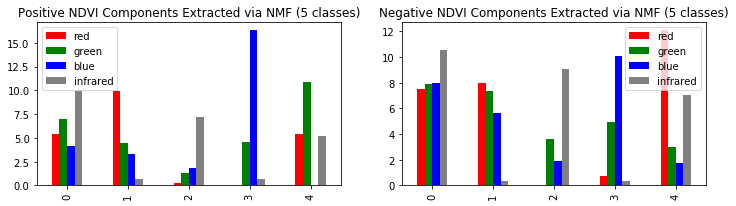

In [21]:
visualize_extracted_classes('StPaulCampus', 5, 5)

On the whole, it seems like the 3 positive/3 negative class model did the best job of classifying the data without introducing the "noise" of more esoteric classes that are unlikely to generalize well to classify other images.  We will proceed with this model to use for classifying the test images, and assess its peformance in the final accuracy assessment step.

## Fit Classifications to Test Data

We can leverage the same `fit_ndvi_segmented_nmf()` function introduced above, this time with `mode="test"`, to apply the trained models to new test images.  This step takes the components "learned" during modeling, and applies them to the test images to extract weights for each pixel in the test images.  It then finds the maximum weight for each pixel when crossed with the components from the models, and uses that as the predicted classification for that pixel.

In [ ]:
# Fit model to test images
for i in range(len(test_images)):
    print("Fitting image " + str(i) + "...")
    
    # Convert the img to a list format
    test_img_df, test_img_metadata = make_img_long(test_images[i], compute_ndvi=True) 
    
    # Run the model and save the results to a file
    filename_to_save = 'TEST' + str(i)
    fit_ndvi_segmented_nmf('StPaulCampus', test_img_df, test_img_metadata, mode = "test",
                           ndvi_neg_components = 5, ndvi_pos_components = 5, 
                           save_to_file = True, filename = filename_to_save)